# Segmentation trained just on eggs
## 05/03/21

Train a Unet just on samples with eggs

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import cv2
import segmentation_models_pytorch as smp
from utils.datatools import PlanktonDataset
from utils.transform_helpers import *
from utils.visualizers import visualize

### Preliminaries
Point to the dataset split by profile for the ResNet training a few weeks ago, desired network, encoder depth, etc.

In [2]:
# file paths
vocpath = '/home/eorenstein/VOCCopepodEgg'
imgset = 'SplitByProfile-230221'

# Unet settings
ENCODER = 'resnet18'
WEIGHTS = 'imagenet'
DEPTH = 5  # desired depth of encoder. default is 5 for resnet-18
DECODE_CHAN = (256, 128, 64, 32, 16)  # must set corresponding filter sizes of decoder. length must match depth
CHANNELS = 3  # set as 1 for gray, 3 for color
ACTIVE = 'softmax2d'
CLASSES = ['copepod', 'eggs']
n_classes = 1 if len(CLASSES) == 1 else ((len(CLASSES) + 1))

### Instatiate model

In [3]:
if DEPTH == 5:
    model = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=CHANNELS,  
        classes=n_classes,
        activation=ACTIVE
    )
else:
    model = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        encoder_depth=DEPTH,
        decoder_channels=DECODE_CHAN,
        in_channels=CHANNELS,  
        classes=n_classes,
        activation=ACTIVE
    )

# this is the preprocessing for imagenet if using 3 channel images
if CHANNELS == 3:
    preprocess = smp.encoders.get_preprocessing_fn(ENCODER, WEIGHTS)
    dmy_clf = True
else:
    preprocess = None
    dmy_clf = False

### Get datasets and loaders

Since only interested in egg data point to that train and val set. 

In [4]:
training_dataset = PlanktonDataset(root=vocpath,
                                   img_set=f'{imgset}/egg_train.txt',
                                   augs=training_transform(),
                                   preproc=get_preprocessing(preprocess),
                                   classes=CLASSES,
                                   dummy_clf=dmy_clf
                                  )

val_dataset = PlanktonDataset(root=vocpath,
                              img_set=f'{imgset}/egg_val.txt',
                              augs=validation_transform(),
                              preproc=get_preprocessing(preprocess),
                              classes=CLASSES,
                              dummy_clf=dmy_clf
                             )

# check that the lengths are consistent
print('train set:', len(training_dataset), 'images')
print('val set:', len(val_dataset), 'images')

train_loader = DataLoader(training_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=1)

train set: 1330 images
val set: 313 images


### Define loss function.

Dice loss is related to F1 score. IoU is intersection over union

In [5]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# standard atom optimizer from PyTorch (might want to consider reducing the learning rate)
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

### Define the epoch runners

In [6]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device='cuda',
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device='cuda',
    verbose=True,
)

### Training cycle

In [7]:
max_score = 0

# where to save
outpath = '/home/eorenstein/python_code/eggs-emantic/clf-outputs'
descript = 'eggs_only'  # info about model

for i in range(0, 15):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, os.path.join(outpath,f'{descript}_best_model.pth'))
        print('Model saved!')
        
    if max_score > 0.94:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 313/313 [00:02<00:00, 124.74it/s, dice_loss - 0.1719, iou_score - 0.9159]
Model saved!

Epoch: 1
valid: 100%|██████████| 313/313 [00:02<00:00, 126.19it/s, dice_loss - 0.08353, iou_score - 0.929] 
Model saved!

Epoch: 2
valid: 100%|██████████| 313/313 [00:02<00:00, 127.53it/s, dice_loss - 0.05844, iou_score - 0.9372]
Model saved!

Epoch: 3
valid: 100%|██████████| 313/313 [00:02<00:00, 128.16it/s, dice_loss - 0.03523, iou_score - 0.9612]
Model saved!
Decrease decoder learning rate to 1e-5!

Epoch: 4
valid: 100%|██████████| 313/313 [00:02<00:00, 125.95it/s, dice_loss - 0.0324, iou_score - 0.9655] 
Model saved!
Decrease decoder learning rate to 1e-5!

Epoch: 5
valid: 100%|██████████| 313/313 [00:02<00:00, 127.47it/s, dice_loss - 0.03151, iou_score - 0.9654]
Decrease decoder learning rate to 1e-5!

Epoch: 6
valid: 100%|██████████| 313/313 [00:02<00:00, 126.67it/s, dice_loss - 0.03008, iou_score - 0.9668]
Model saved!
Decrease decoder learning rate to 1e-5!


### Check the output on the just the eggs in the test set

Prelimiaries in case not running directly after training (all this is cut and pasted from above. redundant if running the whole notebook at once).

In [3]:
descript = 'eggs_only'

# this is the preprocessing for imagenet if using 3 channel images
if CHANNELS == 3:
    preprocess = smp.encoders.get_preprocessing_fn(ENCODER, WEIGHTS)
    dmy_clf = True
else:
    preprocess = None
    dmy_clf = False

Load the best model as measured by validation IoU

In [4]:
best_model = torch.load(f'./clf-outputs/{descript}_best_model.pth')

# loss and optimizer, cut and pasted from above
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# standard atom optimizer from PyTorch (might want to consider reducing the learning rate)
optimizer = torch.optim.Adam([ 
    dict(params=best_model.parameters(), lr=0.0001),
])

Load the test dataset

In [5]:
# this is for running images through the classifier
test_dataset = PlanktonDataset(root=vocpath, 
                               img_set=f'{imgset}/egg_test.txt',
                               augs=validation_transform(),
                               preproc=get_preprocessing(preprocess),
                               classes=CLASSES,
                               dummy_clf=dmy_clf)

# this does not do any preprocessing for plotting
test_viz = PlanktonDataset(root=vocpath, 
                           img_set=f'{imgset}/egg_test.txt',
                           classes=CLASSES,
                           )

Evaluate the model on all the images of the test set.

In [6]:
test_dataloader = DataLoader(test_dataset)

test_epoch = smp.utils.train.ValidEpoch(
    best_model, 
    loss=loss, 
    metrics=metrics, 
    device='cuda',
    verbose=True,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 266/266 [00:02<00:00, 108.89it/s, dice_loss - 0.02358, iou_score - 0.9689]


Randomly select from the test data and visualize

index: 133 img-id: 6681834


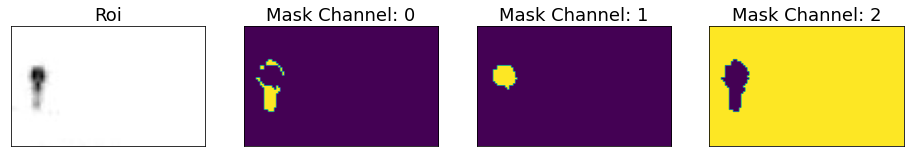

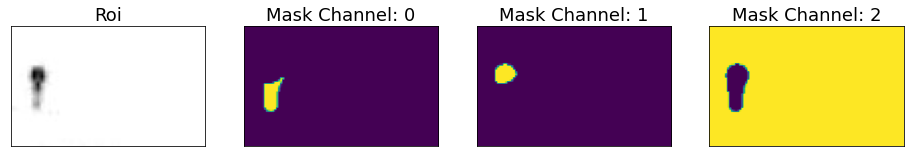

In [7]:
# select a random image from the validation set
ii = np.random.choice(len(test_dataset))
#ii=10
print('index:', ii, 'img-id:', test_viz.ids[ii])
img_orig, gt_mask = test_viz[ii]
img, mask = test_dataset[ii]

mask = mask.squeeze()

# put it on the GPU
imgtens = torch.from_numpy(img).to('cuda').unsqueeze(0)
pred = best_model.predict(imgtens)
pred = (pred.squeeze().cpu().numpy().round())

# rearrange channels for visualization
pred_out = pred.transpose(1,2,0)
pred_out = cv2.resize(pred_out, dsize=(img_orig.shape[1],img_orig.shape[0]))

visualize(ROI=img_orig, mask=gt_mask)
visualize(ROI=img_orig, mask=pred_out)

### Now evaluate on images without eggs

Load in images without eggs to see what it does. First grab a list of image-ids of just copepods.

In [11]:
with open('/home/eorenstein/VOCCopepodEgg/ImageSets/Main/SplitByProfile-230221/cope_test.txt', 'r') as ff:
    copes = list(ff)
    ff.close()
    
copes = [line.strip() for line in copes]
print(len(copes))

13458


There are more in there than we care to process. Select a random 1000.

In [12]:
np.random.shuffle(copes)
copes = copes[0:1000]

Load them as a dataset and procede as above

In [13]:
# this is for running images through the classifier
cope_dataset = PlanktonDataset(root=vocpath, 
                               img_set=copes,
                               augs=validation_transform(),
                               preproc=get_preprocessing(preprocess),
                               classes=CLASSES,
                               dummy_clf=dmy_clf)

# this does not do any preprocessing for plotting
cope_viz = PlanktonDataset(root=vocpath, 
                           img_set=copes,
                           classes=CLASSES,
                           )

Re-instantiate in case not loaded and evaluate the model on all the images of the test set.

In [14]:
cope_dataloader = DataLoader(cope_dataset)

cope_epoch = smp.utils.train.ValidEpoch(
    best_model, 
    loss=loss, 
    metrics=metrics, 
    device='cuda',
    verbose=True,
)

logs = cope_epoch.run(cope_dataloader)

valid: 100%|██████████| 1000/1000 [00:08<00:00, 114.07it/s, dice_loss - 0.02253, iou_score - 0.9713]


Randomly select from copepod ROIs data and visualize

index: 849 img-id: 64100985


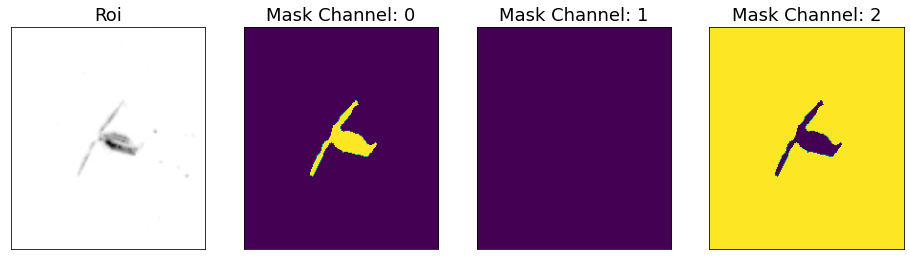

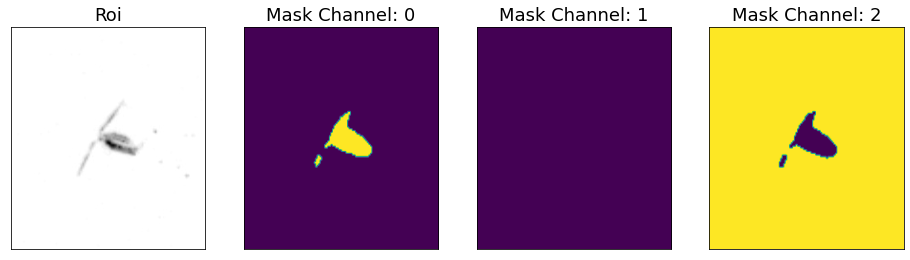

In [31]:
# select a random image from the validation set
ii = np.random.choice(len(cope_dataset))
#ii=10
print('index:', ii, 'img-id:', cope_viz.ids[ii])
img_orig, gt_mask = cope_viz[ii]
img, mask = cope_dataset[ii]

mask = mask.squeeze()

# put it on the GPU
imgtens = torch.from_numpy(img).to('cuda').unsqueeze(0)
pred = best_model.predict(imgtens)
pred = (pred.squeeze().cpu().numpy().round())

# rearrange channels for visualization
pred_out = pred.transpose(1,2,0)
pred_out = cv2.resize(pred_out, dsize=(img_orig.shape[1],img_orig.shape[0]))

visualize(ROI=img_orig, mask=gt_mask)
visualize(ROI=img_orig, mask=pred_out)

In [43]:
num = 0
for jj in range(len(cope_dataset)):
    img, mask = cope_dataset[jj]

    mask = mask.squeeze()

    # put it on the GPU
    imgtens = torch.from_numpy(img).to('cuda').unsqueeze(0)
    pred = best_model.predict(imgtens)
    pred = (pred.squeeze().cpu().numpy().round())
    
    if np.sum(pred[1, :, :]) == 0:
        print(jj)
        num+=1
        
print('total with no egg pixels:', num)

5
9
17
26
37
49
51
52
57
65
66
71
73
80
82
98
100
103
116
130
132
147
152
154
162
166
173
174
175
181
186
187
189
198
213
220
225
230
231
247
265
270
271
275
277
280
301
304
317
318
321
322
324
335
338
340
354
364
365
367
371
382
385
392
404
420
423
441
450
456
462
473
477
484
493
508
516
522
526
537
540
543
558
567
570
576
579
585
602
605
618
619
627
630
639
643
663
667
670
671
673
698
699
702
720
731
734
737
738
742
747
753
757
768
773
776
795
796
797
799
805
819
822
843
845
849
853
860
874
888
900
901
908
911
912
914
916
919
928
933
937
938
958
968
970
973
979
996
total with no egg pixels: 148
